In [1]:
from skimage import io
import matplotlib.pyplot as plt
import numpy as np

In [2]:
IMAGES_PATH = 'data/images/'

In [3]:
image = io.imread('../' + IMAGES_PATH + 'barcode-00-01.jpg')

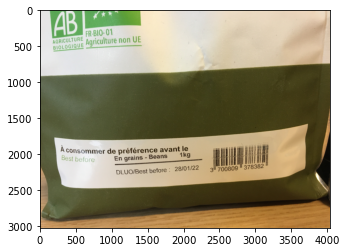

In [4]:
plt.imshow(image)

In [5]:
image = np.array(image).mean(axis=2).astype(np.uint8)

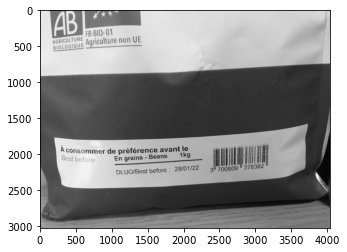

In [6]:
plt.imshow(image, cmap='gray')

In [7]:
tiles = []
n_cols = len(image[0])
n_rows = len(image)

for i in range(0, n_rows, 16):
    for j in range(0, n_cols, 16):
        tiles.append(image[i:i+16, j:j+16])

In [8]:
index_table = [(0, 2), (1, 2), (2, 2), (2, 1), (2, 0), (1, 0), (0, 0), (0, 1)]
padding_row = np.zeros(18).astype(np.uint8).tolist()

In [9]:
def compute_lbp_value(lbp_window):
    lbp_value = 0
    pixel_value = lbp_window[1][1]
    for i in range(8):
        row_index, col_index = index_table[i]
        lbp_value = lbp_value | (int(lbp_window[row_index][col_index] >= pixel_value) << i)
        
    return lbp_value

In [10]:
def pad_tile(tile):
    tileList = tile.tolist()
    
    for i in range(16):
        tileList[i].insert(0, 0)
        tileList[i].append(0)
    tileList.insert(0, padding_row)
    tileList.append(padding_row)    
    return np.array(tileList)

In [11]:
histo_list = []

for tile in tiles:
    padded_tile = pad_tile(tile)
    lbp_histo = [0 for i in range(256)]
    
    for i in range(1, 17):
        for j in range(1, 17):
            window = padded_tile[i-1:i+2, j-1:j+2]
            lbp_histo[compute_lbp_value(window)] += 1    
            
    histo_list.append(lbp_histo)# / np.max(lbp_histo))
    
    

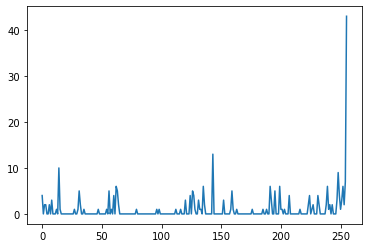

In [12]:
plt.plot(histo_list[0])
plt.show()

In [13]:
from sklearn.cluster import KMeans

In [14]:
histo = np.array(histo_list)

In [15]:
histo.shape

(47628, 256)

In [16]:
n_cluster=16

In [17]:
kmeans = KMeans(n_clusters=n_cluster, random_state=128).fit(histo)

In [18]:
transformed = kmeans.predict(histo)

In [19]:
transformed_reshape = transformed.reshape(image.shape[0] // 16, image.shape[1] // 16)

In [20]:
transformed_reshape.shape

(189, 252)

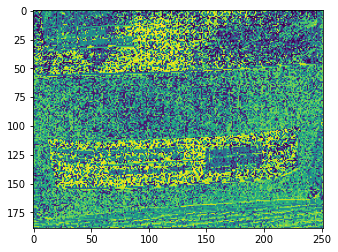

In [21]:
plt.imshow(transformed_reshape)

In [22]:
import matplotlib.cm as cm


In [23]:
def random_lut(n_values):
    samples = np.linspace(0, 1, n_values)
    rng = np.random.default_rng(3)
    samples = rng.permutation(samples)
    colors = cm.hsv(samples, alpha=None, bytes=True)
    return colors[...,:3]

In [24]:
lut = random_lut(n_cluster)

In [25]:
recolored = lut[transformed_reshape]
recolored.shape

(189, 252, 3)

In [27]:
def show_image_seg(img, recolored, n_clusters):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title("Original image")
    plt.subplot(1,2,2)
    plt.imshow(recolored)
    plt.title(f"Classified image with {n_clusters} clusters")

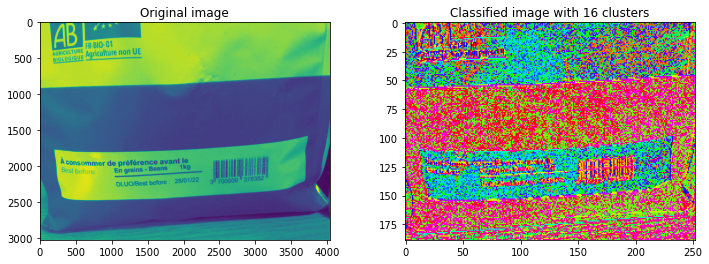

In [28]:
show_image_seg(image, recolored, n_cluster)